In [1]:
import pandas as pd
import numpy as np

#Görselleştirme
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

#cleaning
import re
from bs4 import BeautifulSoup

#nlp
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer,WordNetLemmatizer
import spacy


#modelleme

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from transformers import BertTokenizer

import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

import fasttext


nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emrul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data =pd.read_csv("data/Clothing/Womens Clothing E-Commerce Reviews.csv",index_col=0)
data.head(2)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


In [3]:
len(data)

23486

In [4]:
data = data[["Clothing ID","Review Text","Rating"]]
data.columns = ["clothingID","review","rating"]
data.head()

,clothingID,review,rating
0,767,Absolutely wonderful - silky and sexy and comf...,4
1,1080,Love this dress! it's sooo pretty. i happene...,5
2,1077,I had such high hopes for this dress and reall...,3
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",5
4,847,This shirt is very flattering to all due to th...,5


In [5]:
data.dtypes

clothingID     int64
review        object
rating         int64
dtype: object

In [6]:
data.shape

(23486, 3)

In [7]:
data.isnull().sum()

clothingID      0
review        845
rating          0
dtype: int64

In [8]:
data.dropna(inplace=True)
data.shape

(22641, 3)

In [9]:
data["rating"].value_counts()

rating
5    12540
4     4908
3     2823
2     1549
1      821
Name: count, dtype: int64

<Axes: ylabel='count'>

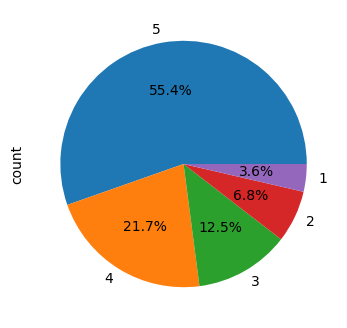

In [10]:
data["rating"].value_counts().plot.pie(autopct='%1.1f%%', figsize=(4,4))

In [11]:
#def stopwords
stopWords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_lg")

with open('data/stopwords-en.txt', 'r',encoding='utf-8') as file:
    stopWords2 = [line.strip() for line in file]

In [12]:
def lemmatize(cleanTokens):
   lemmatizedTokens = [token.lemma_ for token in nlp(" ".join(cleanTokens))]
   return lemmatizedTokens

def cleanReview(review):

    #küçük harf dönüşümü
    review = review.lower()

    #html ayıkla 
    review = BeautifulSoup(review,"html.parser").get_text()

    #yabancı karakter ayıkla
    review= re.sub('[^A-Za-z]'," ",review)
    #text = re.sub(r'[^a-zA-Z\s]', '', text)

    
    #tokenize et
    reviewTokens = word_tokenize(review)

    #StopWords kaldırma
    cleanTokens=[token for token in reviewTokens if token not in stopWords2]

    return cleanTokens

def preProcess(review):
    cleanTokens = cleanReview(review)
    lemmatizedTokens = lemmatize(cleanTokens)
    return " ".join(lemmatizedTokens)

data["cleanReview"]=data["review"].apply(lambda review: preProcess(review))

C:\Users\emrul\AppData\Local\Temp\ipykernel_14068\1269646468.py:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review,"html.parser").get_text()


In [13]:
#data.to_csv("data/Clothing/clothingClear.csv",index=False)
#data =pd.read_csv("data/Clothing/clothingClear.csv")
data.head()

,clothingID,review,rating,cleanReview
0,767,Absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable
1,1080,Love this dress! it's sooo pretty. i happene...,5,love dress sooo pretty happen store glad bc on...
2,1077,I had such high hopes for this dress and reall...,3,hope dress initially petite usual size outrage...
3,1049,"I love, love, love this jumpsuit. it's fun, fl...",5,love love love jumpsuit fun flirty fabulous ti...
4,847,This shirt is very flattering to all due to th...,5,shirt flattering adjustable tie perfect wear l...


In [14]:
#temizlemeden dolayı bazı reviewlerde null değer oluştu
data.isnull().sum()
data.dropna(inplace=True)
data.shape

(22641, 4)

In [15]:
data["review_spacy_vec"] = data["cleanReview"].apply(lambda text: nlp(text).vector)
data.sample(1)

,clothingID,review,rating,cleanReview,review_spacy_vec
7723,936,This sweater is amazing. color is vibrant. qua...,4,sweater amazing color vibrant quality super to...,"[-1.488106, 0.12671652, -2.5911393, -0.937523,..."


In [16]:
print(data.loc[4821] , "\n")
print(data.loc[4821,"review"] , "\n")
print(data.loc[4821,"cleanReview"], "\n")
print(len(data.loc[4821,"review_spacy_vec"]), "\n")

clothingID                                                        829
review              Great shirt!! i bought the red penguins and it...
rating                                                              5
cleanReview         shirt buy red penguin adorable return size buy...
review_spacy_vec    [-2.7886913, 1.515917, -3.6462784, 0.39424977,...
Name: 4821, dtype: object 

Great shirt!! i bought the red penguins and its adorable. i am returning it however b/c the size i bought was too big, with that said it was my error not the brand. i think it runs true to size. 

shirt buy red penguin adorable return size buy error brand run true size 

300 



In [17]:
# bazı algoritmalar 0 1 2 .. şeklinde target değerleri ile çalışıyor
label_encoder = LabelEncoder()
data['rating_encoded'] = label_encoder.fit_transform(data['rating'])

rating_dict = {idx:str(label) for idx, label in enumerate(label_encoder.classes_)}
rating_dict

{0: '1', 1: '2', 2: '3', 3: '4', 4: '5'}

In [19]:
import json
with open("models/ratingDict.json", "w") as json_file:
        json.dump(rating_dict, json_file)

In [18]:
t1 = "I recommend it!"        # 4 puan
t2 = "I dont recommend it! "   # 2 paun
print(preProcess(t1))
print(preProcess(t2))

recommend
recommend


# ML

In [20]:
X = data["review_spacy_vec"]
Y=data["rating_encoded"]
randomState =4
testSize=0.3
x_train, x_test, y_train, y_test =train_test_split(X,Y,test_size=testSize,stratify=Y,random_state=randomState)


In [21]:
x_train = np.stack(x_train)
x_test = np.stack(x_test)

In [22]:
minMaxScaler = MinMaxScaler() 
x_train = minMaxScaler.fit_transform(x_train)
x_test = minMaxScaler.transform(x_test)

In [23]:
modelPairs = [
    {"modelName": "Naive Bayes", "model": MultinomialNB()},
    {"modelName": "KNN", "model": KNeighborsClassifier()},
    {"modelName": "Random Forest", "model": RandomForestClassifier(random_state=randomState, class_weight='balanced')},
    {"modelName": "Logistic Regression", "model": LogisticRegression(random_state=randomState, class_weight='balanced')},
    {"modelName": "CatBoost", "model": CatBoostClassifier(random_state=randomState, verbose=0)},
    {"modelName": "LGBM", "model": lgb.LGBMClassifier(random_state=randomState, verbose=0)},
    {"modelName": "xgb", "model": xgb.XGBClassifier(random_state=randomState)}
]

In [24]:
def calculateMatrics(modelName,y_true,y_predict):
    accuracy = accuracy_score(y_true, y_predict)

    precisionMacro = precision_score(y_true, y_predict, average='macro') 
    precisionWeighted = precision_score(y_true, y_predict, average='weighted')

    recallMacro = recall_score(y_true, y_predict, average='macro') 
    recallWeighted = recall_score(y_true, y_predict, average='weighted')

    f1Macro = f1_score(y_true, y_predict, average='macro') 
    f1Weighted = f1_score(y_true, y_predict, average='weighted')

    return {
            "modelName":modelName,
            "accuracy":accuracy,
            "f1-scoreMacro":f1Macro,
            "f1-scoreWeighted":f1Weighted,
            "precisionMacro":precisionMacro,
            "precisionWeighted":precisionWeighted,
            "recallMacro":recallMacro,
            "recallWeighted":recallWeighted
            }

    

In [25]:
results = []
for modelPair in modelPairs:
    modelName = modelPair["modelName"]
    model= modelPair["model"]

    model.fit(x_train,y_train)
    predictions = model.predict(x_test)
    
    results.append(calculateMatrics(modelName,y_test,predictions))

In [26]:
pd.DataFrame(data=results).sort_values(by="f1-scoreMacro", ascending=False)

,modelName,accuracy,f1-scoreMacro,f1-scoreWeighted,precisionMacro,precisionWeighted,recallMacro,recallWeighted
3,Logistic Regression,0.506551,0.367955,0.531099,0.359159,0.572634,0.411016,0.506551
4,CatBoost,0.592227,0.320041,0.536504,0.415375,0.527635,0.309553,0.592227
5,LGBM,0.584867,0.311337,0.524682,0.419419,0.517080,0.299176,0.584867
6,xgb,0.576770,0.292927,0.519258,0.402261,0.508550,0.286402,0.576770
1,KNN,0.533638,0.277164,0.481928,0.324377,0.461869,0.270783,0.533638
2,Random Forest,0.558958,0.167877,0.414704,0.430731,0.480368,0.211374,0.558958
0,Naive Bayes,0.553805,0.142568,0.394773,0.110761,0.306700,0.200000,0.553805


# bert

In [27]:
train_texts, val_texts, train_labels, val_labels = train_test_split(data['review'].tolist(), 
                                                                    data['rating_encoded'].tolist(), 
                                                                    test_size=0.2, stratify=data['rating_encoded'].tolist(),
                                                                    random_state=5)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [28]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

In [29]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = ReviewDataset(train_encodings, train_labels)
val_dataset = ReviewDataset(val_encodings, val_labels)


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model = model.cuda()


# Eğitim argümanları
training_args = TrainingArguments(
    output_dir='/results', 
    num_train_epochs=1,              
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,                    
    evaluation_strategy="epoch",     
    do_train=True,
    do_eval=True
)


trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=val_dataset             
)

trainer.train()

In [32]:
preds = trainer.predict(val_dataset)
pred_labels = torch.argmax(torch.tensor(preds.predictions), axis=1)

print(classification_report(val_labels, pred_labels.tolist(), zero_division=0))

  0%|          | 0/567 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.54      0.29      0.37       164
           1       0.37      0.32      0.35       310
           2       0.45      0.57      0.50       565
           3       0.53      0.48      0.50       982
           4       0.85      0.88      0.87      2508

    accuracy                           0.69      4529
   macro avg       0.55      0.51      0.52      4529
weighted avg       0.69      0.69      0.69      4529



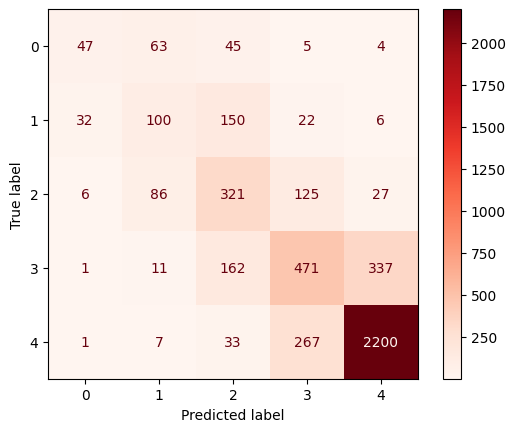

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
cm = confusion_matrix(val_labels, pred_labels.tolist())
class_names = np.unique(val_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Reds')
plt.show()

In [34]:
results.append(calculateMatrics("bert",val_labels,pred_labels.tolist()))
pd.DataFrame(data=results).sort_values(by="f1-scoreMacro", ascending=False)

,modelName,accuracy,f1-scoreMacro,f1-scoreWeighted,precisionMacro,precisionWeighted,recallMacro,recallWeighted
7,bert,0.693089,0.518653,0.688611,0.550031,0.689570,0.506827,0.693089
3,Logistic Regression,0.506551,0.367955,0.531099,0.359159,0.572634,0.411016,0.506551
4,CatBoost,0.592227,0.320041,0.536504,0.415375,0.527635,0.309553,0.592227
5,LGBM,0.584867,0.311337,0.524682,0.419419,0.517080,0.299176,0.584867
6,xgb,0.576770,0.292927,0.519258,0.402261,0.508550,0.286402,0.576770
1,KNN,0.533638,0.277164,0.481928,0.324377,0.461869,0.270783,0.533638
2,Random Forest,0.558958,0.167877,0.414704,0.430731,0.480368,0.211374,0.558958
0,Naive Bayes,0.553805,0.142568,0.394773,0.110761,0.306700,0.200000,0.553805


In [ ]:
#trainer.save_model("models/classificationModels/bert")

# fasttext

In [35]:
fasttextData = data.copy()
fasttextData["textRate"]= "__label__"+fasttextData["rating"].astype(str)+" "+fasttextData["review"]
fasttextData.head(1)

,clothingID,review,rating,cleanReview,review_spacy_vec,rating_encoded,textRate
0,767,Absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable,"[0.039214037, 0.37505996, -2.378078, -2.250537...",3,__label__4 Absolutely wonderful - silky and se...


In [36]:
train, test = train_test_split(fasttextData, test_size=0.2)
train.shape, test.shape

((18112, 7), (4529, 7))

In [37]:
train['textRate'].to_csv('data/Clothing/train.txt', index=False, header=False)
test['textRate'].to_csv('data/Clothing/test.txt', index=False, header=False)

In [38]:
import fasttext
model = fasttext.train_supervised(input='data/Clothing/train.txt')
model.test('data/Clothing/test.txt')

(1146, 0.6631762652705061, 0.6631762652705061)

In [39]:
true_labels = test['rating'].tolist()

predicted_labels = []
for text in test['review']:
    text = text.replace("\n"," ")
    label, _ = model.predict(text)
    predicted_labels.append(int(label[0].replace('__label__', '')))

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           1       0.17      0.03      0.05       148
           2       0.28      0.13      0.18       309
           3       0.35      0.06      0.10       588
           4       0.18      0.02      0.03       939
           5       0.60      0.99      0.75      2545

    accuracy                           0.58      4529
   macro avg       0.32      0.24      0.22      4529
weighted avg       0.45      0.58      0.45      4529



In [40]:
results.append(calculateMatrics("fasttext",true_labels, predicted_labels))
classificationAlgInfo=pd.DataFrame(data=results).sort_values(by="f1-scoreMacro", ascending=False)
classificationAlgInfo

,modelName,accuracy,f1-scoreMacro,f1-scoreWeighted,precisionMacro,precisionWeighted,recallMacro,recallWeighted
7,bert,0.693089,0.518653,0.688611,0.550031,0.689570,0.506827,0.693089
3,Logistic Regression,0.506551,0.367955,0.531099,0.359159,0.572634,0.411016,0.506551
4,CatBoost,0.592227,0.320041,0.536504,0.415375,0.527635,0.309553,0.592227
5,LGBM,0.584867,0.311337,0.524682,0.419419,0.517080,0.299176,0.584867
6,xgb,0.576770,0.292927,0.519258,0.402261,0.508550,0.286402,0.576770
1,KNN,0.533638,0.277164,0.481928,0.324377,0.461869,0.270783,0.533638
8,fasttext,0.576286,0.220884,0.454305,0.316871,0.446853,0.243996,0.576286
2,Random Forest,0.558958,0.167877,0.414704,0.430731,0.480368,0.211374,0.558958
0,Naive Bayes,0.553805,0.142568,0.394773,0.110761,0.306700,0.200000,0.553805


In [ ]:
#classificationAlgInfo.to_csv("models/classificationModels/classificationAlgInfo.csv")